In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 4. Evaluate models more thoroughly
from sklearn.model_selection import GridSearchCV
import optuna
import pandas as pd
import pickle
import numpy as np
PICKLE_DIR = "../../pickle/"
df = pd.read_csv('../../data/log_data_fe.csv')
df

,ATL_OR_DR,CAMPAIGN_TYPE,CHANNEL,COST,FREE_TRIALS,HOLIDAY_FLAG,LAG_3_HOLIDAY_FLAG,LEAD_3_HOLIDAY_FLAG,SEASON,MONTH,CHANNEL_ATL_OR_DR,CHANNEL_CAMPAIGN_TYPE,COST_PER_FREE_TRIALS,COST_BY_FREE_TRIALS,LOG_COST,LOG_FREE_TRIALS,LOG_COST_PER_FREE_TRIALS,LOG_COST_BY_FREE_TRIALS
0,DR - Direct Response,Title,paid social,7784.31,86401.15,False,False,False,Summer,June,paid social_DR - Direct Response,paid social_Title,0.090095,6.725733e+08,8.959994,11.366768,0.086265,20.326622
1,DR - Direct Response,Title,app,2474.31,2956.74,False,False,False,Summer,August,app_DR - Direct Response,app_Title,0.836837,7.315891e+06,7.814121,7.992181,0.608045,15.805560
2,ATL - Above The Line,Title,paid social,10222.82,12513.08,False,False,False,Summer,July,paid social_ATL - Above The Line,paid social_Title,0.816971,1.279190e+08,9.232476,9.434610,0.597171,18.666908
3,DR - Direct Response,Title,app,49631.87,17207.04,False,True,False,Winter,December,app_DR - Direct Response,app_Title,2.884393,8.540176e+08,10.812409,9.753132,1.356967,20.565462
4,ATL - Above The Line,Title,paid social,2081.06,21758.33,False,False,False,Summer,August,paid social_ATL - Above The Line,paid social_Title,0.095644,4.528039e+07,7.641113,9.987798,0.091343,17.628385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14103,ATL - Above The Line,Brand,bvod,1478.78,16941.67,False,False,False,Winter,February,bvod_ATL - Above The Line,bvod_Brand,0.087287,2.505300e+07,7.299649,9.737591,0.083685,17.036504
14104,ATL - Above The Line,Title,ooh,839.25,5727.03,False,False,False,Spring,April,ooh_ATL - Above The Line,ooh_Title,0.146542,4.806410e+06,6.733699,8.653127,0.136750,15.385461
14105,ATL - Above The Line,Title,bvod,193796.71,34824.51,False,False,False,Winter,December,bvod_ATL - Above The Line,bvod_Title,5.564952,6.748875e+09,12.174570,10.458105,1.881745,22.632642
14106,ATL - Above The Line,Brand,paid social,84690.65,25140.77,False,False,False,Winter,February,paid social_ATL - Above The Line,paid social_Brand,3.368658,2.129188e+09,11.346772,10.132286,1.474456,21.479007


In [ ]:
'''
Train-Test Split: Any data preprocessing or feature engineering step that uses information about the entire dataset
(e.g., calculating the mean, variance, or creating features based on all the data) should be done on the training set
only to prevent data leakage. These steps typically don't use any aggregate statistics or insights from the data.


Example Walkthrough - Suppose you have a dataset with columns: age, income, and purchased. You decide to:

1. Remove entries where age < 0 (business rule): Before split.
2. Normalize income (scaling): After split (use training set statistics).
3. Impute missing age with the median: After split (calculate median from training set).
4. One-hot encode purchased: After split (fit encoder on training set categories).


Key Takeaways
1. Perform global operations (business rules, data cleaning) before the train-test split.
2. Perform statistical or data-dependent operations (scaling, encoding, outlier detection) after the train-test split, using only the training set to avoid leakage.
3. Always ensure the transformations applied to the training set are identically applied to the test set.

'''

In [4]:
# Split the data into training and testing sets
# X = df.drop(columns=['LOG_FREE_TRIALS', 'REPORT_DATE', 'COST', 'FREE_TRIALS'])
y = df['FREE_TRIALS']
X = df.drop(columns=['LOG_FREE_TRIALS', 'FREE_TRIALS'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_columns = ['ATL_OR_DR', 'CAMPAIGN_TYPE', 'CHANNEL', 'HOLIDAY_FLAG',
                       'LAG_3_HOLIDAY_FLAG', 'LEAD_3_HOLIDAY_FLAG', 'SEASON',
                       'CHANNEL_ATL_OR_DR', 'CHANNEL_CAMPAIGN_TYPE', 'MONTH']
numerical_columns = ['LOG_COST', 'COST', 'COST_PER_FREE_TRIALS','COST_BY_FREE_TRIALS',
                     'LOG_COST_PER_FREE_TRIALS', 'LOG_COST_BY_FREE_TRIALS']
[]
# Redefine the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Redefine pipelines for XGBoost and Random Forest
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])



# Define hyperparameter grids for XGBoost and Random Forest
xgb_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

rf_param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# GridSearch for XGBoost
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
xgb_grid_search.fit(X_train, y_train)

# GridSearch for Random Forest
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best parameters and scores for both models
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = -xgb_grid_search.best_score_

rf_best_params = rf_grid_search.best_params_
rf_best_score = -rf_grid_search.best_score_

xgb_best_params, xgb_best_score, rf_best_params, rf_best_score

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 81 candidates, totalling 243 fits


({'model__learning_rate': 0.2,
  'model__max_depth': 3,
  'model__n_estimators': 200},
 397932053.6335671,
 {'model__max_depth': 20,
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 2,
  'model__n_estimators': 200},
 534514332.0629363)

XGBoost Results:
MSE: 53577736.7143
RMSE: 7319.6815
MAE: 2888.5458
R2 Score: 0.9827

Random Forest Results:
MSE: 32214079.2012
RMSE: 5675.7448
MAE: 969.6162
R2 Score: 0.9896



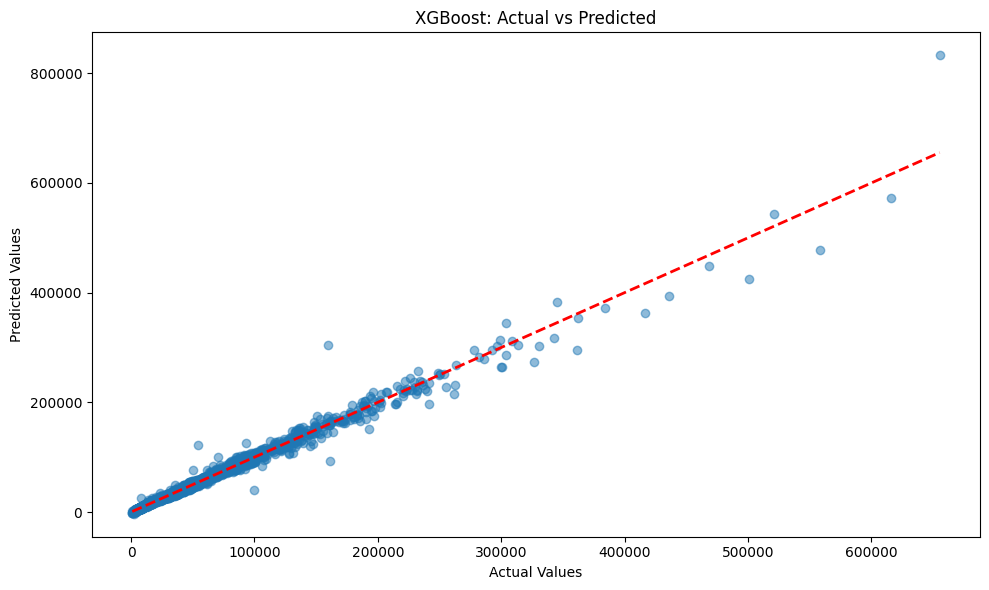

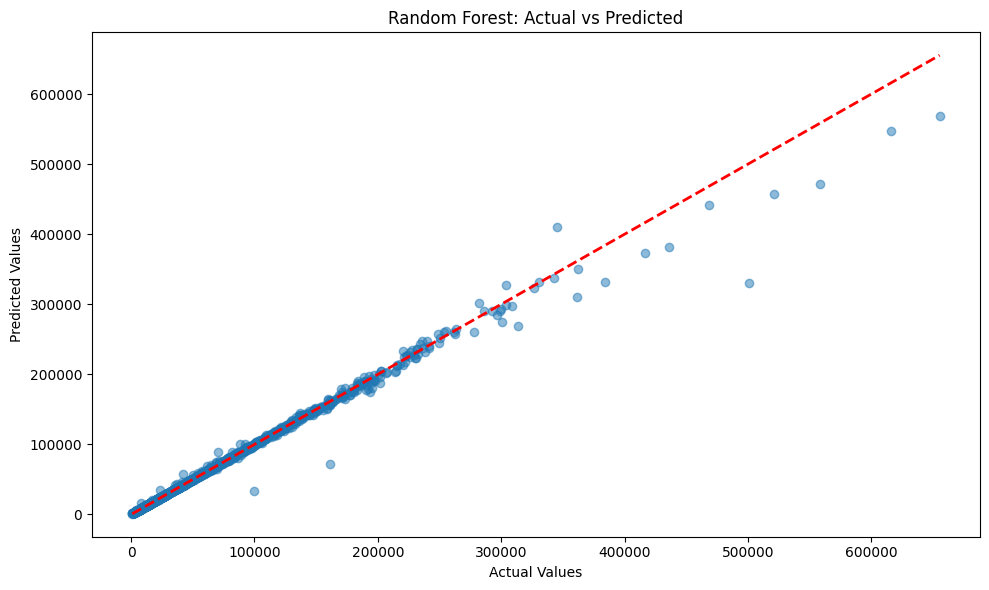

In [5]:
# 1. Get the best models and their scores
xgb_best_model = xgb_grid_search.best_estimator_
rf_best_model = rf_grid_search.best_estimator_

# 2. Get cross-validation results
xgb_cv_results = pd.DataFrame(xgb_grid_search.cv_results_)
rf_cv_results = pd.DataFrame(rf_grid_search.cv_results_)

# 3. Make predictions
xgb_predictions = xgb_best_model.predict(X_test)
rf_predictions = rf_best_model.predict(X_test)

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}\n")

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate both models
xgb_metrics = evaluate_model(y_test, xgb_predictions, "XGBoost")
rf_metrics = evaluate_model(y_test, rf_predictions, "Random Forest")

# 5. Optional: Plot actual vs predicted
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_predictions(y_test, xgb_predictions, 'XGBoost: Actual vs Predicted')
plot_predictions(y_test, rf_predictions, 'Random Forest: Actual vs Predicted')

In [6]:
xgb_pickle_file = f"{PICKLE_DIR}/xgb_best_model_log_data_init.pkl"
rf_pickle_file = f"{PICKLE_DIR}/rf_best_model_log_data_init.pkl"

# Save the models
with open(xgb_pickle_file, 'wb') as f:
    pickle.dump(xgb_best_model, f)

with open(rf_pickle_file, 'wb') as f:
    pickle.dump(rf_best_model, f)

print("Models saved successfully!")


Models saved successfully!


In [10]:
# Extract feature names from the preprocessor
preprocessor = xgb_best_model.named_steps['preprocessor']  # Same for rf_best_model

# Get numerical and categorical feature names
numerical_features = numerical_columns
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Combine all feature names
all_feature_names = list(numerical_features) + list(categorical_features)


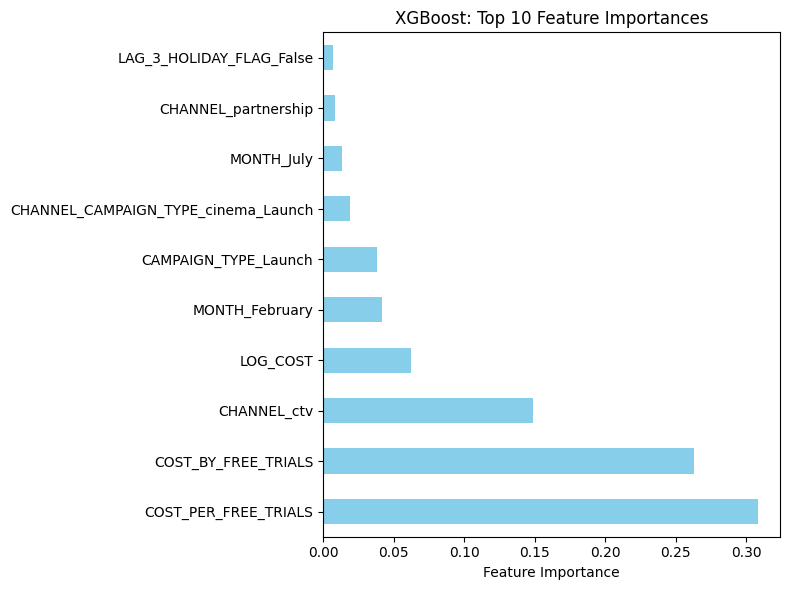

In [8]:
# Get feature importances from XGBoost
xgb_feature_importances = xgb_best_model.named_steps['model'].feature_importances_

# Create a pandas Series for feature importances
xgb_importances = pd.Series(xgb_feature_importances, index=all_feature_names)

# Plot the top 10 most important features
xgb_importances.nlargest(10).plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.title("XGBoost: Top 10 Feature Importances")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


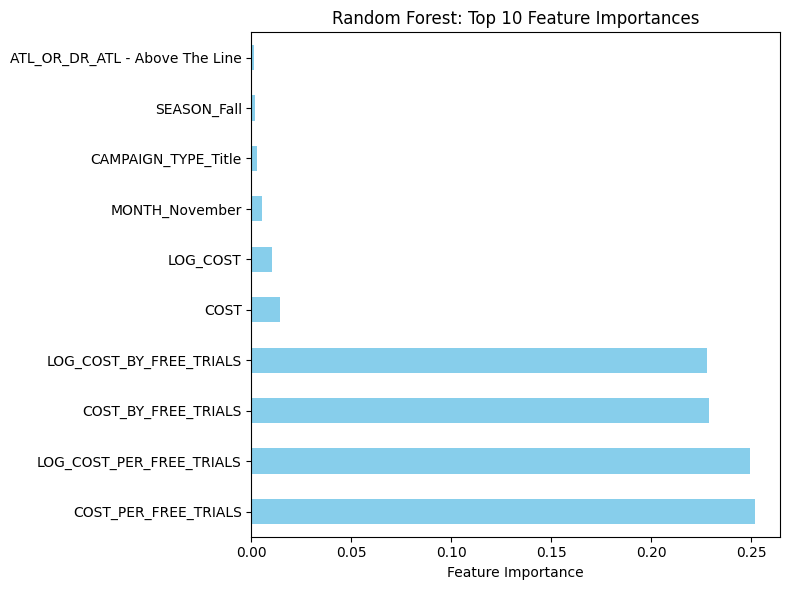

In [9]:
# Get feature importances from Random Forest
rf_feature_importances = rf_best_model.named_steps['model'].feature_importances_

# Create a pandas Series for feature importances
rf_importances = pd.Series(rf_feature_importances, index=all_feature_names)

# Plot the top 10 most important features
rf_importances.nlargest(10).plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.title("Random Forest: Top 10 Feature Importances")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score", color="r")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
    plt.plot(train_sizes, test_mean, label="Validation score", color="g")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.2)

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


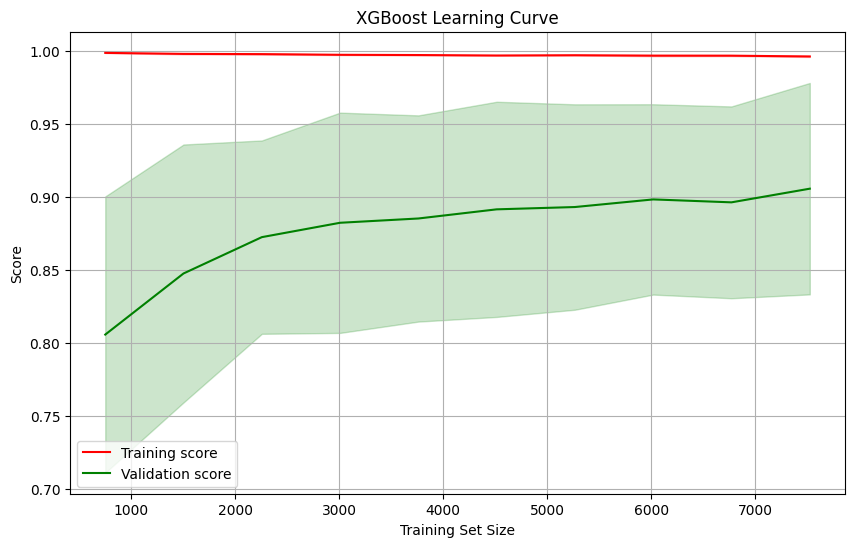

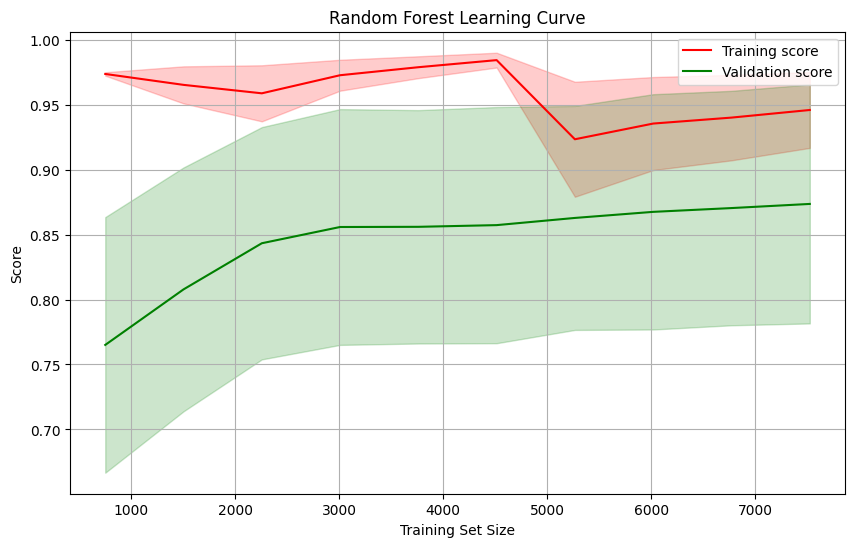

In [12]:
# Learning curve for XGBoost
plot_learning_curve(xgb_best_model, X_train, y_train, title="XGBoost Learning Curve")

# Learning curve for Random Forest
plot_learning_curve(rf_best_model, X_train, y_train, title="Random Forest Learning Curve")
